In [1]:
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)
from collections import OrderedDict
import math
import numpy as np
import sympy as sp
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import qmc
import scipy.io

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))    

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))
        x = torch.tanh(x)

        cheby = torch.ones(x.shape[0], self.inputdim, self.degree + 1, 
                          device=x.device)
        
        if self.degree > 0:
            cheby[:, :, 1] = x
        
        for i in range(2, self.degree + 1):
            cheby[:, :, i] = 2 * x * cheby[:, :, i - 1].clone() - cheby[:, :, i - 2].clone()

        y = torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)  
        y = y.view(-1, self.outdim)
        return y

# 修改DNNLayer，不再需要hidden_dim参数
class DNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, activation=nn.Tanh):
        super(DNNLayer, self).__init__()
        # 直接使用输入维度作为内部隐藏层维度（从layer_sizes推导）
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim),  # 隐藏层维度 = 输入维度
            activation(),
            nn.Linear(input_dim, output_dim)
        )
        
    def forward(self, x):
        return self.layer(x)

# 混合模型：仅使用layer_sizes定义所有维度
class HybridKAN_DNN(nn.Module):
    def __init__(self, layer_sizes, cheby_degree, lb, ub):
        super(HybridKAN_DNN, self).__init__()
        self.lb = lb
        self.ub = ub
        self.layers = nn.ModuleList()
        
        # 完全通过layer_sizes定义各层维度
        for i in range(len(layer_sizes) - 1):
            if i % 2 == 0:  # 偶数索引：ChebyKAN层
                self.layers.append(ChebyKANLayer(
                    input_dim=layer_sizes[i],
                    output_dim=layer_sizes[i+1],
                    degree=cheby_degree
                ))
            else:  # 奇数索引：DNN层（内部维度自动从layer_sizes[i]获取）
                self.layers.append(DNNLayer(
                    input_dim=layer_sizes[i],
                    output_dim=layer_sizes[i+1]
                ))
    
    def forward(self, x):
        out = 2 * (x - self.lb) / (self.ub - self.lb) - 1
        for layer in self.layers:
            out = layer(out)
        return out

In [4]:
# the physics-guided neural network
class PIKDN(torch.nn.Module):
    def __init__(self, X_d, X_res, r_d, q_d, layers, degree, lb, ub):
        super(PIKDN, self).__init__()
        
        self.z_d = torch.tensor(X_d[:, 0:1], requires_grad=True).double().to(device)
        self.t_d = torch.tensor(X_d[:, 1:2], requires_grad=True).double().to(device)
        self.r_d = torch.tensor(r_d).double().to(device)
        self.q_d = torch.tensor(q_d).double().to(device)

        self.z_res = torch.tensor(X_res[:, 0:1], requires_grad=True).double().to(device)
        self.t_res = torch.tensor(X_res[:, 1:2], requires_grad=True).double().to(device)

        self.lb = torch.tensor(lb).double().to(device)
        self.ub = torch.tensor(ub).double().to(device)

        # -------------------------- 1. 修复 A1/A2/A3 的 Parameter 定义 --------------------------
        # 步骤：先创建指定 dtype 和 device 的 Tensor，再用 Parameter 包装（确保最终是 Parameter 类型）
        self.c1 = torch.nn.Parameter(
            torch.tensor([3.0], dtype=torch.float64, device=device),  # 直接指定 dtype=double（float64）和 device
            requires_grad=True  # 可训练，默认 True 可省略，但显式写更清晰
        )
        self.c2 = torch.nn.Parameter(
            torch.tensor([3.0], dtype=torch.float64, device=device),
            requires_grad=True
        )

        self.d1 = torch.nn.Parameter(
            torch.tensor([3.0], dtype=torch.float64, device=device),  # 直接指定 dtype=double（float64）和 device
            requires_grad=True  # 可训练，默认 True 可省略，但显式写更清晰
        )
        self.d2 = torch.nn.Parameter(
            torch.tensor([3.0], dtype=torch.float64, device=device),
            requires_grad=True
        )
        self.d3 = torch.nn.Parameter(
            torch.tensor([3.0], dtype=torch.float64, device=device),
            requires_grad=True
        )

        # -------------------------- 2. 子模块初始化（无修改） --------------------------
        self.layers = layers
        self.net = HybridKAN_DNN(layers, degree, self.lb, self.ub).to(device)

        self.iter = 0

        # -------------------------- 3. 修复优化器参数（无重复，包含所有可训练参数） --------------------------
        # self.parameters() 自动包含：
        # - 主模块的 A1/A2/A3（Parameter 类型）
        # - 子模块 self.net 的所有可训练参数（因 net 是 self 的子模块）
        self.optimizer1 = torch.optim.Adam(self.parameters(), lr=1e-3)  # 直接用 self.parameters()
        self.optimizer2 = torch.optim.LBFGS(
            self.parameters(),  # 同样用 self.parameters()，无重复
            lr=1.0,
            max_iter=20000,
            max_eval=20000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        self.c1s = []
        self.c2s = []
        self.d1s = []
        self.d2s = []
        self.d3s = []

        self.loss_history = {
            'total': [],
            'residual': [],
            'd': []
        }
        
    def net_h(self, z, t):  
        H = self.net(torch.cat([z, t], dim=1))
        q = H[:, 0:1]
        r = H[:, 1:2]
        return q, r
        
    def gradient(self, y, x):
        return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]           
    
    def net_f(self, z, t):

        q, r = self.net_h(z, t)
        q_t = self.gradient(q, t)
        q_z = self.gradient(q, z)

        r_t = self.gradient(r, t)
        r_z = self.gradient(r, z)
        r_zz = self.gradient(r_z, z)
        r_zzz = self.gradient(r_zz, z)

        f1 = r_t - self.c1 * q_z - self.c2 * r * r_z
        f2 = q_t - self.d1 * r_zzz - self.d2 * r * q_z - self.d3 * q * r_z

        return f1, f2


    def loss_func(self):

        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()

        f1_p, f2_p = self.net_f(self.z_res, self.t_res)

        q_d_p, r_d_p = self.net_h(self.z_d, self.t_d)

        loss_d = torch.mean((r_d_p-self.r_d)**2) + torch.mean((q_d_p-self.q_d)**2)

        loss_res = torch.mean(f1_p**2) + torch.mean(f2_p**2)
        
        loss = loss_res + loss_d

        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            self.c1s.append(self.c1.item())
            self.c2s.append(self.c2.item())
            self.d1s.append(self.d1.item())
            self.d2s.append(self.d2.item())
            self.d3s.append(self.d3.item())

            self.loss_history['total'].append(loss.item())
            self.loss_history['residual'].append(loss_res.item())
            self.loss_history['d'].append(loss_d.item())

            print(
                'Iter %d, Loss: %.5e, Loss_res: %.5e, Loss_d: %.5e, c1: %.5e, c2: %.5e, d1: %.5e, d2: %.5e, d3: %.5e' % 
                (   self.iter, 
                    loss.item(), 
                    loss_res.item(),  
                    loss_d.item(),
                    self.c1.item(),
                    self.c2.item(),
                    self.d1.item(),
                    self.d2.item(),
                    self.d3.item()
                )
            )

        return loss
    
    def train(self):
        self.net.train()
        print("采用Adam优化器")
        for i in range(10000):
            self.optimizer1.step(self.loss_func)
        # 然后运行lbfgs优化器
        print("采用L-BFGS优化器")
        self.optimizer2.step(self.loss_func) 
            
    def predict(self, X):
        
        z = torch.tensor(X[:, 0:1], requires_grad=True).double().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).double().to(device)

        self.net.eval()
        q, r = self.net_h(z, t)
        r = r.detach().cpu().numpy()
        q = q.detach().cpu().numpy()

        return q, r



In [5]:
N_res = 10000

x = np.linspace(-10, 10, 201)
t = np.linspace(0, 1, 201) 

x_mesh, t_mesh = np.meshgrid(x, t)

X = np.hstack((x_mesh.flatten()[:,None], t_mesh.flatten()[:,None]))

lb = X.min(0) #下界x'QxQ
ub = X.max(0)  #上界 

def lhs(n, size):
    """生成n维拉丁超立方采样，返回size个样本点"""
    sampler = qmc.LatinHypercube(d=n)
    return sampler.random(n=size)

# 使用简洁形式进行采样（与你要求的形式一致）
X_res = lb + (ub - lb) * lhs(2, N_res)  # 2维残差点采样

In [6]:
def read_four_columns_by_index(mat_path):
    """
    不按名称，按列索引读取MAT文件中的前四列数据
    :param mat_path: MAT文件路径
    :return: col1, col2, col3, col4（四列数据）
    """
    # 加载MAT文件
    mat_data = scipy.io.loadmat(mat_path)
    # 过滤系统键，获取自定义变量
    custom_keys = [k for k in mat_data.keys() if not k.startswith('__')]
    if not custom_keys:
        raise ValueError("MAT文件中无自定义变量")
    
    # 提取第一个自定义变量
    data_var = mat_data[custom_keys[0]]
    
    # 处理结构体嵌套
    if data_var.dtype == 'object' or data_var.shape == (1, 1):
        # 打印结构体字段名，方便用户确认
        field_names = data_var[0, 0].dtype.names
        print(f"结构体字段名：{field_names}")
        # 假设数据在第一个字段中（或替换为实际字段名，如'data'）
        data_2d = data_var[0, 0][field_names[0]]
    else:
        data_2d = data_var
    
    # 确保是二维数组
    if data_2d.ndim == 1:
        # 若一维，尝试重塑为4列（需长度是4的倍数）
        if len(data_2d) % 4 == 0:
            data_2d = data_2d.reshape(-1, 4)
        else:
            raise ValueError("一维数据长度不是4的倍数，无法分为四列")
    elif data_2d.ndim > 2:
        # 若多维，取前两维（或根据实际情况调整）
        data_2d = data_2d.reshape(-1, data_2d.shape[-1])
    
    # 检查列数是否≥4
    if data_2d.shape[1] < 4:
        raise ValueError(f"数据只有{data_2d.shape[1]}列，不足4列")
    
    # 按索引读取四列并压缩维度
    col1 = np.squeeze(data_2d[:, 0])
    col2 = np.squeeze(data_2d[:, 1])
    col3 = np.squeeze(data_2d[:, 2])
    col4 = np.squeeze(data_2d[:, 3])
    
    return col1, col2, col3, col4

# 调用函数
mat_path = "/kaggle/input/jm-case5-anly/case5_analytical_solution_data.mat"
col1, col2, col3, col4 = read_four_columns_by_index(mat_path)

# 输出结果
print(f"第一列数据长度：{len(col1)}")
print(f"第二列前5个值：{col2[:5]}")

第一列数据长度：40401
第二列前5个值：[0. 0. 0. 0. 0.]


In [7]:
x_d = col1.reshape(-1, 1)
t_d = col2.reshape(-1, 1)
X_d = np.hstack((x_d, t_d))
r_d = col3.reshape(-1, 1)
q_d = col4.reshape(-1, 1)

n_select = 500  # 要选取的数量
# 生成500个不重复的随机行索引（replace=False表示不重复抽样）
random_indices = np.random.choice(X_d.shape[0], size=n_select, replace=False)
# 可选：对索引排序（使数据保持原数组的顺序，非必需，根据需求选择）
random_indices = np.sort(random_indices)

X_d_selected = X_d[random_indices]  # 形状：(500, 2)
r_d_selected = r_d[random_indices]  # 形状：(500, 1)
q_d_selected = q_d[random_indices]  # 形状：(500, 1)

In [8]:
degree = 3
layers = [2] + 4 * [24] + [2]

model = PIKDN(X_d_selected, X_res, r_d_selected, q_d_selected, layers, degree, lb, ub)

In [9]:
def count_parameters(model):
    """计算模型中可训练参数的总个数"""
    total_params = 0
    for param in model.parameters():
        # 累加每个参数张量的元素数量
        total_params += param.numel()
    return total_params

param_count = count_parameters(model)
print(f"模型可训练参数总个数: {param_count:,}")  # 使用逗号作为千位分隔符

模型可训练参数总个数: 5,093


In [10]:
for name, param in model.named_parameters():
    if param.requires_grad:  # 只保留可训练参数
        print(f"参数名称: {name:20}")  # 左对齐，占20字符，避免排版混乱
        print(f"  - 形状: {param.shape}")  # 参数的维度（如卷积层权重：[16,3,3,3]）
        print(f"  - 设备: {param.device}")  # 参数所在设备（cpu/cuda:0）
        print(f"  - 数据类型: {param.dtype}")  # 参数数据类型（如torch.float32）
        print(f"  - 是否可训练: {param.requires_grad}")
        print(f"  - 参数数量: {param.numel()}")  # 该参数的总元素数
        print("-"*80)

参数名称: c1                  
  - 形状: torch.Size([1])
  - 设备: cuda:0
  - 数据类型: torch.float64
  - 是否可训练: True
  - 参数数量: 1
--------------------------------------------------------------------------------
参数名称: c2                  
  - 形状: torch.Size([1])
  - 设备: cuda:0
  - 数据类型: torch.float64
  - 是否可训练: True
  - 参数数量: 1
--------------------------------------------------------------------------------
参数名称: d1                  
  - 形状: torch.Size([1])
  - 设备: cuda:0
  - 数据类型: torch.float64
  - 是否可训练: True
  - 参数数量: 1
--------------------------------------------------------------------------------
参数名称: d2                  
  - 形状: torch.Size([1])
  - 设备: cuda:0
  - 数据类型: torch.float64
  - 是否可训练: True
  - 参数数量: 1
--------------------------------------------------------------------------------
参数名称: d3                  
  - 形状: torch.Size([1])
  - 设备: cuda:0
  - 数据类型: torch.float64
  - 是否可训练: True
  - 参数数量: 1
--------------------------------------------------------------------------------
参数名称:

In [11]:
model.train()

采用Adam优化器
Iter 100, Loss: 2.85429e-02, Loss_res: 2.03634e-03, Loss_d: 2.65066e-02, c1: 2.97864e+00, c2: 2.90812e+00, d1: 2.95945e+00, d2: 2.98788e+00, d3: 2.98629e+00
Iter 200, Loss: 1.55577e-02, Loss_res: 2.47046e-03, Loss_d: 1.30872e-02, c1: 3.09409e+00, c2: 2.76672e+00, d1: 2.78453e+00, d2: 2.83838e+00, d3: 2.91721e+00
Iter 300, Loss: 1.10592e-02, Loss_res: 2.74198e-03, Loss_d: 8.31724e-03, c1: 3.13029e+00, c2: 2.71742e+00, d1: 2.62138e+00, d2: 2.68439e+00, d3: 2.81223e+00
Iter 400, Loss: 8.55439e-03, Loss_res: 2.11121e-03, Loss_d: 6.44318e-03, c1: 3.08132e+00, c2: 2.73053e+00, d1: 2.46018e+00, d2: 2.56472e+00, d3: 2.71071e+00
Iter 500, Loss: 6.16650e-03, Loss_res: 1.09884e-03, Loss_d: 5.06766e-03, c1: 2.99781e+00, c2: 2.78192e+00, d1: 2.33757e+00, d2: 2.47303e+00, d3: 2.63137e+00
Iter 600, Loss: 5.21142e-03, Loss_res: 7.12039e-04, Loss_d: 4.49938e-03, c1: 2.90983e+00, c2: 2.83852e+00, d1: 2.24812e+00, d2: 2.40940e+00, d3: 2.58784e+00
Iter 700, Loss: 4.82498e-03, Loss_res: 5.61601e-

In [12]:
q_pred, r_pred = model.predict(X)

In [13]:
r_true = r_d
q_true = q_d

In [14]:
L2 = np.linalg.norm(r_pred.flatten() - r_true.flatten())/np.linalg.norm(r_true.flatten())

print (L2)

0.0007639429012102558


In [15]:
L2 = np.linalg.norm(q_pred.flatten() - q_true.flatten())/np.linalg.norm(q_true.flatten())

print (L2)

0.004628535891652068


In [16]:
data = {
    'x': x_mesh.flatten()[:, None],
    't': t_mesh.flatten()[:, None],
    'r_pred': r_pred.flatten()[:, None],
    'q_pred': q_pred.flatten()[:, None]
}

scipy.io.savemat('all_data.mat', data)

In [17]:
loss_total = model.loss_history['total']
loss_residual = model.loss_history['residual']
loss_d = model.loss_history['d']
c1s = model.c1s
c2s = model.c2s
d1s = model.d1s
d2s = model.d2s
d3s = model.d3s

In [18]:
num_iterations = len(loss_total)  # 损失记录的总数量（即总迭代次数）
iter_steps = list(range(100, 100 + num_iterations * 100, 100))

In [19]:
# 3. 将数据转换为竖排（列向量）：通过reshape(-1, 1)实现，形状变为(n, 1)
iter_steps_col = np.array(iter_steps).reshape(-1, 1)       # 竖排迭代步数
loss_total_col = np.array(loss_total).reshape(-1, 1)       # 竖排总损失
loss_residual_col = np.array(loss_residual).reshape(-1, 1) # 竖排残差损失
loss_d_col = np.array(loss_d).reshape(-1, 1)               # 竖排数据损失
c1s_col = np.array(c1s).reshape(-1, 1)                    # 竖排 c1 变化
c2s_col = np.array(c2s).reshape(-1, 1)
d1s_col = np.array(d1s).reshape(-1, 1)                    # 竖排 d1 变化
d2s_col = np.array(d2s).reshape(-1, 1)
d3s_col = np.array(d3s).reshape(-1, 1)

# 4. 整理并保存为mat文件（此时所有数据均为列向量）
data_loss = {
    'iter_steps': iter_steps_col,
    'loss_total': loss_total_col,
    'loss_residual': loss_residual_col,
    'loss_d': loss_d_col,
    'c1s': c1s_col,
    'c2s': c2s_col,
    'd1s': d1s_col,
    'd2s': d2s_col,
    'd3s': d3s_col
}

scipy.io.savemat('loss_history.mat', data_loss)
print("竖排格式的损失函数和迭代步数已保存为 loss_history.mat")

竖排格式的损失函数和迭代步数已保存为 loss_history.mat


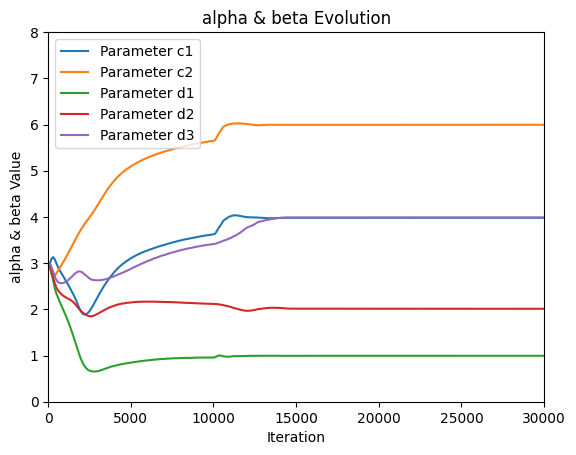

In [20]:
plt.plot(iter_steps, c1s, label='Parameter c1')
plt.plot(iter_steps, c2s, label='Parameter c2')
plt.plot(iter_steps, d1s, label='Parameter d1')
plt.plot(iter_steps, d2s, label='Parameter d2')
plt.plot(iter_steps, d3s, label='Parameter d3')

plt.xlabel('Iteration')
plt.ylabel('alpha & beta Value')
plt.title('alpha & beta Evolution')
plt.legend()
plt.xlim(0, max(iter_steps))  # 设置 x 轴的起始和终止值
plt.ylim(0,8)  # 设置 y 轴的起始和终止值
plt.grid(False)
plt.show()

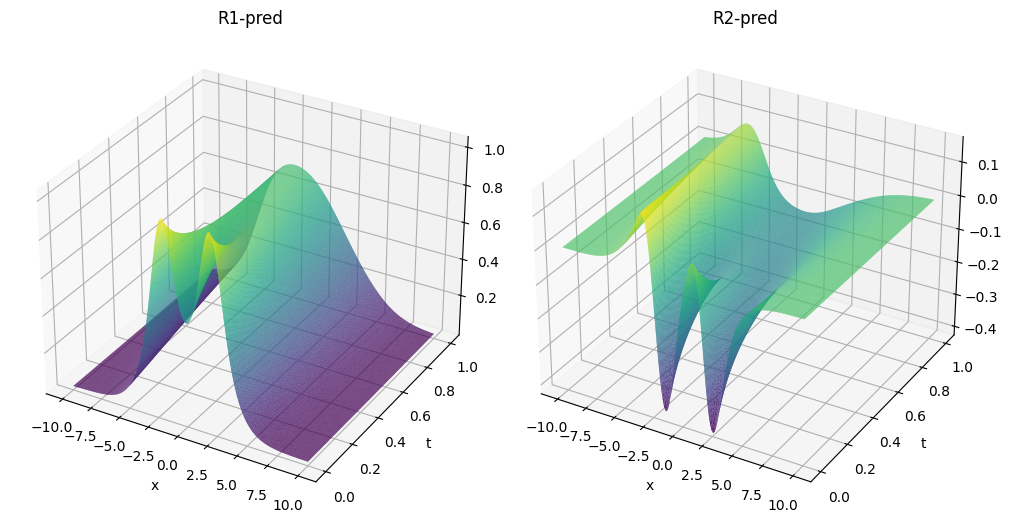

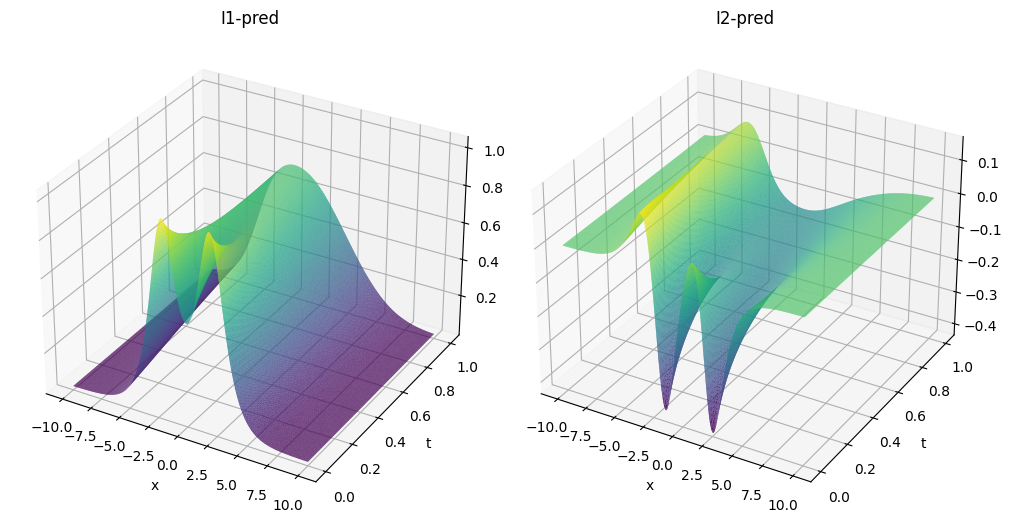

In [21]:
x_values = x_mesh.flatten()
t_values = t_mesh.flatten()

fig = plt.figure(figsize=(15, 10))

# 画r的预测图
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(x_values, t_values, r_pred.flatten(), cmap='viridis')
ax1.set_title("R1-pred")
ax1.set_xlabel('x')
ax1.set_ylabel('t')

# 画r的解析解图
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(x_values, t_values, q_pred.flatten(), cmap='viridis')
ax2.set_title("R2-pred")
ax2.set_xlabel('x')
ax2.set_ylabel('t')

# 调整布局
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_trisurf(x_values, t_values, r_true.flatten(), cmap='viridis')
ax1.set_title("I1-pred")
ax1.set_xlabel('x')
ax1.set_ylabel('t')

# 画q的解析解图
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(x_values, t_values, q_true.flatten(), cmap='viridis')
ax2.set_title("I2-pred")
ax2.set_xlabel('x')
ax2.set_ylabel('t')


# 调整布局
plt.tight_layout()
plt.show()